In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo de Seaborn
sns.set_theme(style="darkgrid")

# Ruta al archivo de periodograma (ajustar según tu archivo)
archivo_periodograma = "periodogramas/datos1_periodograma.csv"

# Cargar los datos del archivo
periodograma = pd.read_csv(archivo_periodograma)

# Calcular los períodos en minutos
periodograma['periodo'] = 1 / periodograma['frecuencia']

# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=periodograma['periodo'], 
    y=periodograma['potencia'], 
    color='blue', 
    linewidth=2, 
    label="Potencia"
)

# Etiquetas y título
plt.xlabel("Período (minutos)", fontsize=14)
plt.ylabel("Potencia", fontsize=14)
plt.title("Periodograma de Lomb-Scargle", fontsize=16)

# Ajustar los ticks del eje x
plt.xticks(
    np.linspace(periodograma['periodo'].min(), periodograma['periodo'].max(), 10), 
    rotation=45, 
    fontsize=12
)

# Agregar leyenda
plt.legend(loc="upper right", fontsize=12)

# Mostrar gráfica
plt.tight_layout()  # Ajusta el diseño para evitar cortes
plt.show()

# Paralelizar el cálculo
num_cores = cpu_count() - 1
with Pool(processes=num_cores) as pool:
    resultados = pool.map(calcular_periodograma, lista_archivos)

# Guardar los resultados generales
output_file = "resultados.txt"
resumen_file = "resumen.txt"

output_data = pd.DataFrame({
    'archivo': [res['archivo'] for res in resultados],
    'periodicidad_maxima_minutos': [
        res['periodo_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'poder_maximo': [
        res['poder_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'intervalo_confianza': [
        res['intervalo_confianza'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'significativo': [
        res['significativo'] if res['mensaje'] is None else "NA" for res in resultados
    ]
})

output_data.to_csv(output_file, sep='\t', index=False, header=True)

# Generar el resumen
resumen_lines = []
for res in resultados:
    if res['mensaje'] is None:
        resumen_lines.append(
            f"Archivo: {res['archivo']}\n"
            f"  Período Máximo: {res['periodo_maximo']:.2f} minutos\n"
            f"  Poder Máximo: {res['poder_maximo']:.4f}\n"
            f"  Intervalo de Confianza: {res['intervalo_confianza']}\n"
            f"  Significativo: {'Sí' if res['significativo'] else 'No'}\n"
        )
    else:
        resumen_lines.append(f"Archivo: {res['archivo']}\n  Error: {res['mensaje']}\n")

with open(resumen_file, "w") as resumen:
    resumen.write("\n".join(resumen_lines))


In [ ]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
from scipy.signal import lombscargle
from multiprocessing import Pool, cpu_count
import os

# Crear la carpeta para guardar los periodogramas
os.makedirs("periodogramas", exist_ok=True)

# Función para calcular el periodograma con intervalo de confianza mediante bootstrap
def calcular_periodograma(archivo, n_bootstrap=1000, confidence_level=0.95):
    resultado = {
        'archivo': archivo,
        'mensaje': None,
        'periodo_maximo': np.nan,
        'poder_maximo': np.nan,
        'intervalo_periodo': None,
        'significativo': False,
        'frecuencias': None,
        'potencias': None
    }

    # Leer los datos del archivo
    try:
        data = pd.read_csv(archivo, header=None, sep=r'\s+')
    except Exception as e:
        resultado['mensaje'] = f"Error al leer el archivo: {e}"
        return resultado

    # Transformar las fechas
    data.iloc[:, 0] -= data.iloc[:, 0].min()
    data.iloc[:, 0] *= 24 * 60  # Convertir a minutos
    data.iloc[:, 1] *= 10**8  # Escalar el flujo
    data = data.dropna()  # Eliminar NaNs

    if len(data) == 0 or data.iloc[:, 1].var() == 0:
        resultado['mensaje'] = "Datos insuficientes o constantes."
        return resultado

    # Calcular el periodograma de Lomb-Scargle
    try:
        time = data.iloc[:, 0].values
        flux = data.iloc[:, 1].values

        # Rango de períodos (50 a 200 minutos)
        frequency = np.linspace(1 / 150, 1 / 50, 1000)
        angular_frequency = 2 * np.pi * frequency

        power = lombscargle(time, flux, angular_frequency)

        # Guardar las frecuencias y potencias para graficar
        resultado['frecuencias'] = frequency
        resultado['potencias'] = power

        # Máximo valor del periodograma
        max_index = np.argmax(power)
        periodo_maximo = 1 / frequency[max_index]
        poder_maximo = power[max_index]

        # Bootstrap para calcular el intervalo de confianza del período
        bootstrap_periods = []
        for _ in range(n_bootstrap):
            # Resamplear los datos con reemplazo
            indices = np.random.choice(len(time), len(time), replace=True)
            resampled_time = time[indices]
            resampled_flux = flux[indices]

            # Calcular el periodograma para el conjunto resampleado
            resampled_power = lombscargle(resampled_time, resampled_flux, angular_frequency)

            # Obtener el período máximo del resampleo
            resampled_max_index = np.argmax(resampled_power)
            resampled_period = 1 / frequency[resampled_max_index]
            bootstrap_periods.append(resampled_period)

        # Calcular el intervalo de confianza
        lower_bound = np.percentile(bootstrap_periods, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_periods, (1 + confidence_level) / 2 * 100)
        intervalo_periodo = (lower_bound, upper_bound)

        # Significancia estadística
        global_threshold = np.mean(power) + 2 * np.std(power)
        significativo = poder_maximo > global_threshold

        # Actualizar resultados
        resultado.update({
            'periodo_maximo': periodo_maximo,
            'poder_maximo': poder_maximo,
            'intervalo_periodo': intervalo_periodo,
            'significativo': significativo
        })

        # Guardar los datos del periodograma en un archivo
        periodograma_file = f"periodogramas/{os.path.basename(archivo).split('.')[0]}_periodograma.csv"
        pd.DataFrame({'frecuencia': frequency, 'potencia': power}).to_csv(
            periodograma_file, index=False
        )

    except Exception as e:
        resultado['mensaje'] = str(e)

    return resultado
# Leer la lista de archivos
with open("lista.txt", "r") as file:
    lista_archivos = [line.strip() for line in file.readlines()]

# Paralelizar el cálculo
num_cores = cpu_count() - 1
with Pool(processes=num_cores) as pool:
    resultados = pool.map(calcular_periodograma, lista_archivos)

# Guardar los resultados generales
output_file = "resultados.txt"
resumen_file = "resumen.txt"

output_data = pd.DataFrame({
    'archivo': [res['archivo'] for res in resultados],
    'periodicidad_maxima_minutos': [
        res['periodo_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'poder_maximo': [
        res['poder_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'intervalo_periodo': [
        res['intervalo_periodo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'significativo': [
        res['significativo'] if res['mensaje'] is None else "NA" for res in resultados
    ]
})

output_data.to_csv(output_file, sep='\t', index=False, header=True)

# Generar el resumen
resumen_lines = []
for res in resultados:
    if res['mensaje'] is None:
        resumen_lines.append(
            f"Archivo: {res['archivo']}\n"
            f"  Período Máximo: {res['periodo_maximo']:.2f} minutos\n"
            f"  Intervalo del Período: {res['intervalo_periodo']}\n"
            f"  Poder Máximo: {res['poder_maximo']:.4f}\n"
            f"  Significativo: {'Sí' if res['significativo'] else 'No'}\n"
        )
    else:
        resumen_lines.append(f"Archivo: {res['archivo']}\n  Error: {res['mensaje']}\n")

with open(resumen_file, "w") as resumen:
    resumen.write("\n".join(resumen_lines))


/tmp/ipykernel_32585/2323568569.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nuevo_data = pd.read_csv(archivo_nuevo, delim_whitespace=True, header=None, names=["frecuencia", "potencia"])
/home/wattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/wattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/wattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futu

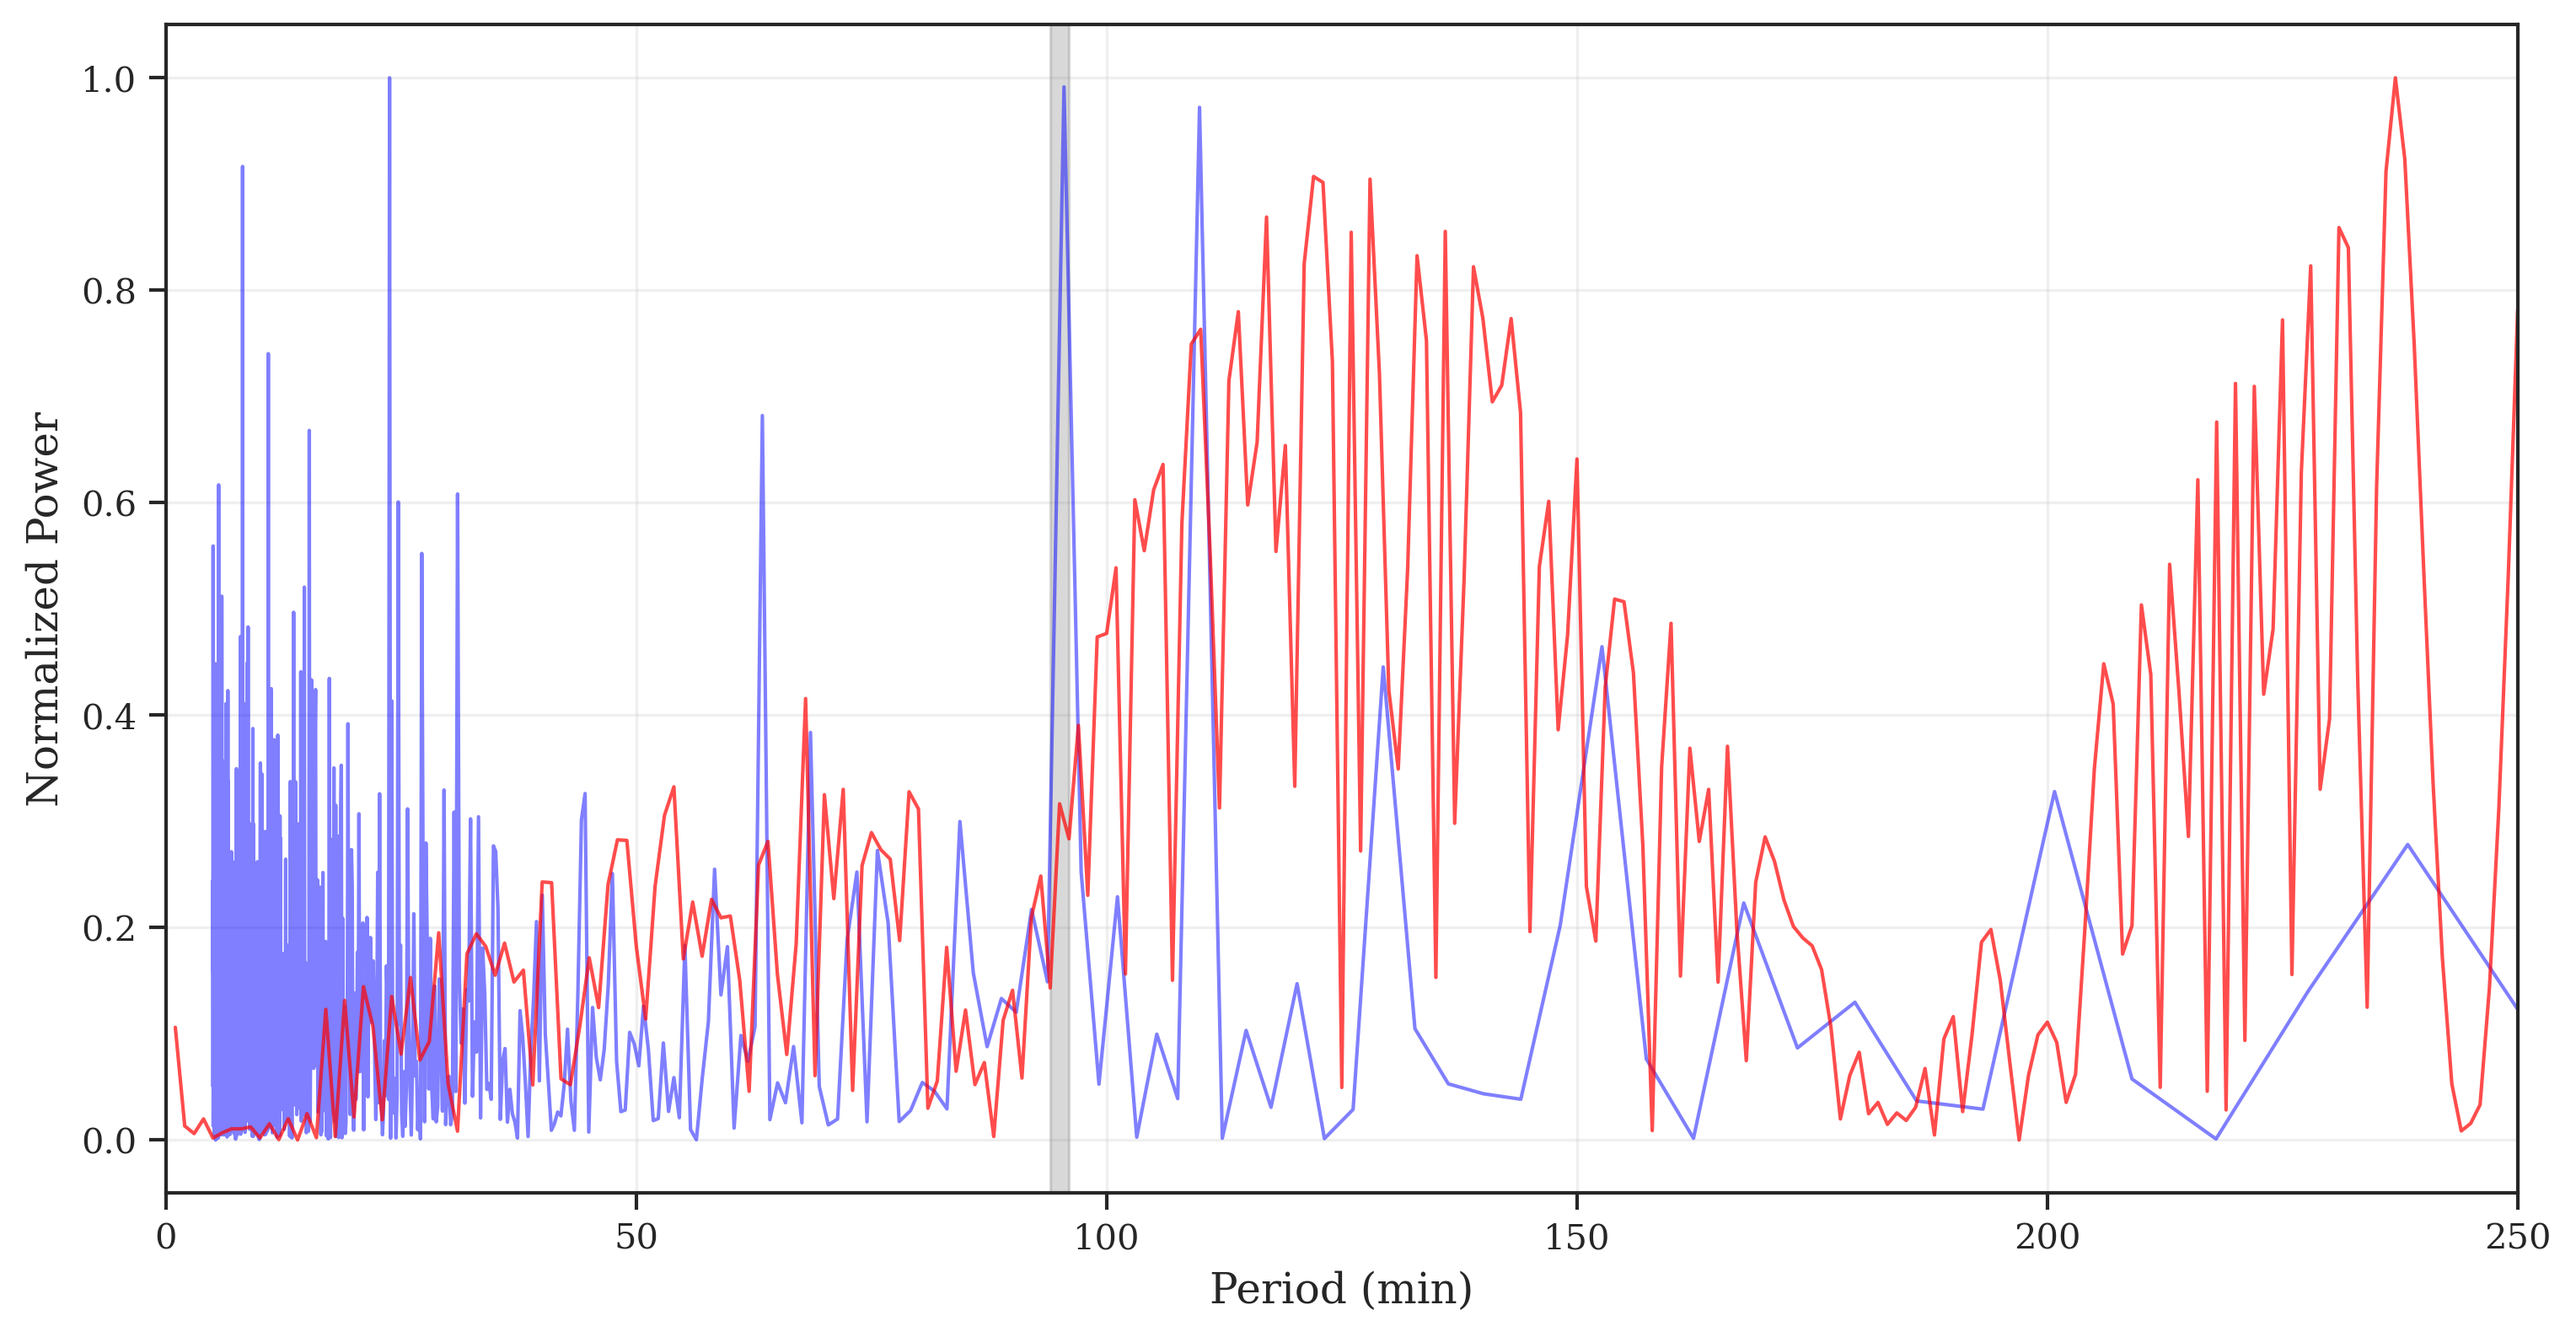

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import MinMaxScaler

# Configuración avanzada de Seaborn y Matplotlib
sns.set_context("paper", font_scale=1.5)  # Ajuste de tamaño de fuente para publicaciones
sns.set_style("ticks")  # Estilo limpio con ticks visibles
sns.set_palette("muted")  # Paleta de colores suave y profesional

# Configuración adicional de Matplotlib
plt.rcParams.update({
    "axes.titlesize": 14,      # Tamaño de los títulos de los ejes
    "axes.labelsize": 12,      # Tamaño de las etiquetas de los ejes
    "xtick.labelsize": 10,     # Tamaño de las etiquetas del eje X
    "ytick.labelsize": 10,     # Tamaño de las etiquetas del eje Y
    "legend.fontsize": 10,     # Tamaño de la leyenda
    "font.family": "serif",    # Tipo de fuente: preferido en publicaciones científicas
    "figure.dpi": 300,         # Resolución de la figura
    "savefig.dpi": 300,        # Resolución de exportación
    "figure.figsize": (10, 6), # Tamaño de la figura (ajustado)
    "axes.grid": True,         # Activar cuadrícula
    "grid.alpha": 0.3,         # Transparencia de la cuadrícula
    "lines.linewidth": 2,      # Grosor de las líneas
})

# Rutas de los archivos de periodograma y nuevo archivo
archivo_periodograma = "sagA-clean-gamma_periodograma.csv"
archivo_nuevo = "sagA-gamma-wf-serie.dat"

# Cargar los datos del archivo de periodograma
periodograma = pd.read_csv(archivo_periodograma)

# Cargar los datos del archivo nuevo (asegúrate de que tenga las mismas columnas que el anterior)
nuevo_data = pd.read_csv(archivo_nuevo, delim_whitespace=True, header=None, names=["frecuencia", "potencia"])

# Normalización Min-Max de la columna 'potencia' para ambos DataFrames
scaler = MinMaxScaler()

periodograma['potencia'] = scaler.fit_transform(periodograma[['potencia']])
nuevo_data['potencia'] = scaler.fit_transform(nuevo_data[['potencia']])

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar el periodograma original
sns.lineplot(
    x=1/periodograma['frecuencia'], 
    y=periodograma['potencia'], 
    color='blue', 
    linewidth=1, 
    alpha=0.5, 
    #label="Periodograma Original"
)

# Graficar el nuevo archivo
sns.lineplot(
    x=nuevo_data['frecuencia'], 
    y=nuevo_data['potencia'], 
    color='red', 
    linewidth=1, 
    alpha=0.7, 
#    label="Nuevo Periodograma"
)

# Sombrear la región entre x=94 y x=100
plt.axvspan(94, 96, color='gray', alpha=0.3)

# Etiquetas y título
plt.xlabel("Period (min)")
plt.ylabel("Normalized Power")  # Cambio en el título del eje Y para indicar normalización
plt.xlim(0, 250)  # Ajusta los límites del eje X según sea necesario

# Agregar leyenda
#plt.legend(loc="upper right", fontsize=12)

# Mostrar la gráfica
plt.show()


In [47]:
import pandas as pd

# Cargar el archivo CSV
filename = "sagA-clean-gamma_periodograma.csv"
data = pd.read_csv(filename)

# Verificar que las columnas sean las correctas
if "frecuencia" in data.columns and "potencia" in data.columns:
    # Calcular el período como el inverso de la frecuencia
    data["periodo"] = 1 / data["frecuencia"]

    # Ordenar los datos por la columna 'potencia' en orden descendente
    top_5 = data.nlargest(5, 'potencia')

    # Configurar pandas para mostrar números completos
    pd.set_option('display.float_format', '{:.16f}'.format)

    # Reordenar las columnas para que 'periodo' esté a la izquierda
    top_5 = top_5[["periodo", "frecuencia", "potencia"]]

    # Mostrar los 5 valores más altos con la nueva columna
    print("Top 5 valores más altos de la columna 'potencia':")
    print(top_5)
else:
    print("El archivo no contiene las columnas 'frecuencia' y 'potencia'.")


Top 5 valores más altos de la columna 'potencia':
                 periodo         frecuencia                  potencia
194  23.7743931461209321 0.0420620620620620 10323817.2558697927743196
33   95.4701834862392076 0.0104744744744744 10235675.9460176900029182
26  109.8768147822261483 0.0091011011011011 10036779.7094353716820478
605   8.1500456859417820 0.1226986986986987  9462303.5416310485452414
448  10.8818787852381149 0.0918958958958959  7642873.3883436713367701


## Checamos los valores de la window function

In [48]:

nuevo_data.iloc[90:100]

,frecuencia,potencia
90,91.0000000000000000,0.0583412849614896
91,92.0000000000000000,0.2094904873440880
92,93.0000000000000000,0.2484938203333475
93,94.0000000000000000,0.1431518582915944
94,95.0000000000000000,0.3165064991178969
95,96.0000000000000000,0.2835876478018510
96,97.0000000000000000,0.3903250901766148
97,98.0000000000000000,0.2303532517236585
98,99.0000000000000000,0.4735670121181697
99,100.0000000000000000,0.4768893944100001


## Checamos los valores del Lomb-Scargle

In [51]:

periodograma.iloc[30:40]

,frecuencia,potencia
30,0.0098858858858858,0.2289907371281356
31,0.0100820820820820,0.0525603311285775
32,0.0102782782782782,0.2523601339164551
33,0.0104744744744744,0.9914622212122403
34,0.0106706706706706,0.1489101940158514
35,0.0108668668668668,0.2170291185629197
36,0.0110630630630630,0.1202590296629166
37,0.0112592592592592,0.1331804780271774
38,0.0114554554554554,0.0878490761360603
39,0.0116516516516516,0.1574809899212586
